# Modélisation de la fréquence de sinistres auto

## 1. Chargement des données et des librairies

In [9]:
import pandas as pd
import numpy as np

# Visualisation 
import matplotlib.pyplot as plt

# Pré-traitement et modèles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, PoissonRegressor

# Métriques
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance


### 1.1 Chargement du jeu de données

On utilise le jeu de données `freMTPL2freq` (fréquence de sinistres en assurance auto).


In [11]:

df = pd.read_csv("C:/Users/marln/Downloads/freMTPL2freq.csv.zip")
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  int64  
 5   VehAge      678013 non-null  int64  
 6   DrivAge     678013 non-null  int64  
 7   BonusMalus  678013 non-null  int64  
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 62.1+ MB


### 1.2 Description générale

Chaque ligne correspond à un contrat d’assurance automobile.

Variables principales :
- `IDpol` : identifiant de police (technique, pas prédictif).
- `ClaimNb` : nombre de sinistres observés sur la période (variable cible).
- `Exposure` : durée d’exposition (en années, entre 0 et 1).
- `Area`, `Region` : informations géographiques.
- `VehPower`, `VehAge`, `VehBrand`, `VehGas` : caractéristiques du véhicule.
- `DrivAge` : âge du conducteur.
- `BonusMalus` : coefficient bonus-malus.
- `Density` : densité de population de la zone de résidence.


In [13]:
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


## 2. Analyse descriptive et visualisation

On s’intéresse d’abord à la distribution de la variable cible `ClaimNb` et de l’exposition `Exposure`. On crée aussi la fréquence

In [15]:
df.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [16]:
df['Frequence'] = df['ClaimNb'] / df['Exposure']
df['Frequence'].describe()

count    678013.000000
mean          0.263964
std           4.593915
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         732.000000
Name: Frequence, dtype: float64

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

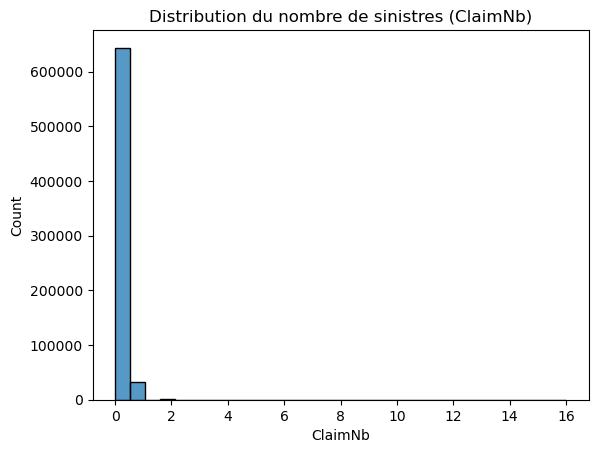

In [18]:
# Histogramme du nombre de sinistres
plt.figure()
sns.histplot(df["ClaimNb"], bins=30)
plt.title("Distribution du nombre de sinistres (ClaimNb)")
plt.show()

Les données sont vraiment déséquilibrées

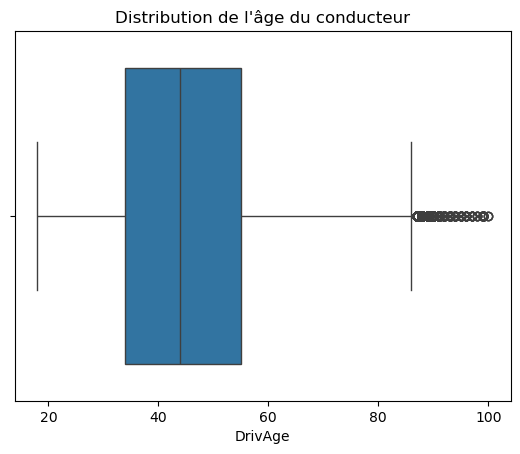

In [20]:
# Distribution de l'âge du conducteur
plt.figure()
sns.boxplot(x=df["DrivAge"])
plt.title("Distribution de l'âge du conducteur")
plt.show()

les ages se concentrent entre 30 et 60 ans, il y'a des valeurs aberrentes entre 85 et 100

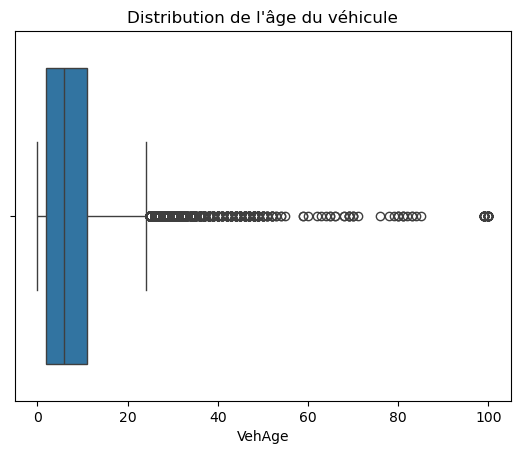

In [22]:
# Distribution de l'âge du véhicule
plt.figure()
sns.boxplot(x=df["VehAge"])
plt.title("Distribution de l'âge du véhicule")
plt.show()

les véhicules ont entre 0 et 15 ans.

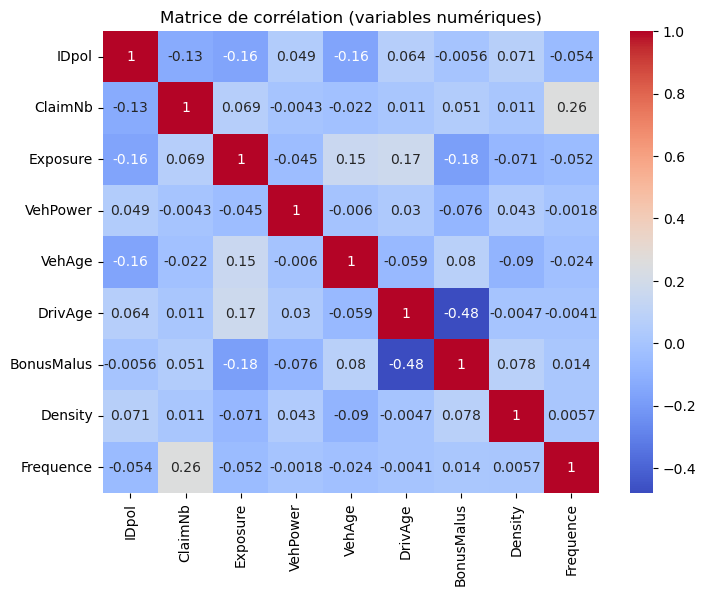

In [24]:
# Corrélation entre variables numériques
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=True)
plt.title("Matrice de corrélation (variables numériques)")
plt.show()

La matrice de corrélation ne révèle que des corrélations faibles entre les variables numériques et la variable cible.
Ceci est attendu dans un contexte de données de sinistres très déséquilibrées (ClaimNb ≈ 0 dans la majorité des contrats).
La corrélation linéaire n’est pas adaptée pour évaluer la pertinence des variables dans un modèle de Poisson ou dans un modèle non linéaire.
Les variables peuvent avoir une réelle importance prédictive malgré une corrélation proche de zéro.

**Interprétation :**

- La moyenne de `ClaimNb` est très faible (environ 0,05), ce qui signifie qu’une très grande
  partie des contrats n’ont aucun sinistre sur la période (données très déséquilibrées).
- La fréquence moyenne (`ClaimNb / Exposure`) est également faible, avec beaucoup de valeurs nulles
  et quelques valeurs très élevées lorsqu’un sinistre survient sur une petite exposition.
- Ce comportement est typique de données de **comptage rare**, bien adaptées à un modèle de Poisson.


## 3. Nettoyage et pré-traitement

On applique quelques règles simples de nettoyage pour éliminer certaines valeurs aberrantes :

- on retire les conducteurs de moins de 18 ans,
- on garde les véhicules avec un âge raisonnable (par exemple ≤ 30 ans),
- on supprime les lignes avec `Exposure` nul (sinon division par zéro pour la fréquence).

In [28]:
# Filtrage simple des valeurs aberrantes
df = df[df['DrivAge'] >= 18]
df = df[df['VehAge'] <= 30]
df = df[df['Exposure'] > 0]

df.shape

(676897, 13)

### 3.1 Encodage des variables catégorielles

Les modèles de scikit-learn ne gèrent pas directement les variables catégorielles, on utilise donc
un **one-hot encoding** via `pd.get_dummies`, en supprimant une modalité de référence (`drop_first=True`).

In [30]:
cat_cols = ['Area', 'VehBrand', 'VehGas', 'Region']

df1 = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df1.head()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Frequence,Area_B,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,1.0,1,0.10,5,0,55,50,1217,10.000000,False,...,False,False,False,False,False,True,False,False,False,False
1,3.0,1,0.77,5,0,55,50,1217,1.298701,False,...,False,False,False,False,False,True,False,False,False,False
2,5.0,1,0.75,6,2,52,50,54,1.333333,True,...,False,False,False,False,False,False,False,False,False,False
3,10.0,1,0.09,7,0,46,50,76,11.111111,True,...,False,False,True,False,False,False,False,False,False,False
4,11.0,1,0.84,7,0,46,50,76,1.190476,True,...,False,False,True,False,False,False,False,False,False,False


L’option `drop_first=True` supprime la première modalité de chaque variable catégorielle,
ce qui évite la **colinéarité parfaite** (la catégorie manquante pouvant être déduite des autres colonnes).


## 4. Définition de la cible et séparation train / test

On cherche à prédire le **nombre de sinistres `ClaimNb`** à partir des autres variables.

On retire donc de X :
- `ClaimNb` (cible),
- `Frequence` (dérivée de `ClaimNb` et `Exposure`),
- `IDpol` (identifiant technique, pas informatif).

On conserve `Exposure` dans `df1` pour éventuellement l’utiliser comme **poids** dans
la régression de Poisson, mais on ne l’inclut pas comme variable explicative
dans X pour ce modèle.

In [34]:
# Variable cible
y = df1['ClaimNb']

# Features : on enlève ClaimNb, Frequence et IDpol
X = df1.drop(columns=['ClaimNb', 'Frequence', 'IDpol'])

# On garde Exposure à part pour la régression de Poisson (poids)
exposure = df1['Exposure']

X_train, X_test, y_train, y_test, exp_train, exp_test = train_test_split(
    X, y, exposure, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((541517, 43), (135380, 43))

## 5. Entraînement des modèles

On compare plusieurs modèles de régression sur la variable de comptage `ClaimNb` :

- Régression linéaire (baseline, pas adaptée théoriquement mais utile comme référence simple),
- Arbre de décision,
- Forêt aléatoire,
- Gradient Boosting,
- SVR linéaire (modèle à marge maximale),
- Régression de Poisson (`PoissonRegressor`) avec `Exposure` comme poids.

On utilise le **MSE** (Mean Squared Error) pour avoir une première comparaison, puis la
**Poisson deviance**, plus adaptée aux données de comptage.

### 5.1 Régression linéaire (baseline)

In [37]:
lin_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

lin_pipeline.fit(X_train, y_train)
y_pred_lin = lin_pipeline.predict(X_test)

mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print(f"[Linear Regression] MSE = {mse_lin:.6f}")
print(f"[Linear Regression] R²  = {r2_lin:.6f}")

[Linear Regression] MSE = 0.057193
[Linear Regression] R²  = 0.012396


### 5.2 Arbre de décision

In [39]:
tree = DecisionTreeRegressor(max_depth=10, random_state=42)

tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"[Decision Tree] MSE = {mse_tree:.6f}")

[Decision Tree] MSE = 0.057129


### 5.3 Forêt aléatoire

In [41]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"[Random Forest] MSE = {mse_rf:.6f}")

[Random Forest] MSE = 0.056007


### 5.4 Gradient Boosting

In [43]:
gb = GradientBoostingRegressor(random_state=42)

gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f"[Gradient Boosting] MSE = {mse_gb:.6f}")

[Gradient Boosting] MSE = 0.056125


### 5.5 SVR linéaire

In [55]:
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', LinearSVR(random_state=42))
])

svr_pipeline.fit(X_train, y_train)
y_pred_svr = svr_pipeline.predict(X_test)

mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"[SVR] MSE = {mse_svr:.6f}")

C:\Users\marln\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[SVR] MSE = 0.060792


### 5.6 Régression de Poisson (GLM de Poisson)

In [57]:
#X_train, X_test, y_train, y_test, exp_train, exp_test = train_test_split(
#   X, y, exposure, test_size=0.2, random_state=42
#)

X_train2= X_train.copy()
X_test2= X_test.copy()

X_train_pois= X_train2.drop(columns=["Exposure", "Density"])
X_test_pois= X_test2.drop(columns=["Exposure", "Density"])


pois = PoissonRegressor(alpha=1e-4, max_iter=1000)

# On utilise l'exposition comme poids (approximation de l'offset)
pois.fit(X_train_pois, y_train, sample_weight=exp_train)
y_pred_pois = pois.predict(X_test_pois)

mse_pois = mean_squared_error(y_test, y_pred_pois)
print(f"[Poisson Regression] MSE = {mse_pois:.6f}")

[Poisson Regression] MSE = 0.057835


## 6. Comparaison des modèles

On compare maintenant les modèles sur deux métriques :

- **MSE** : erreur quadratique moyenne (classique, mais pas idéale pour des données de Poisson),
- **Poisson deviance** : métrique adaptée aux données de comptage (plus petite = meilleur modèle).

In [59]:
def safe_pred(y_pred):
    # La deviance de Poisson nécessite des prédictions strictement positives
    return np.maximum(y_pred, 1e-9)

results = pd.DataFrame({
    'Modèle': [
        'Régression linéaire',
        'Arbre de décision',
        'Forêt aléatoire',
        'Gradient Boosting',
        'SVR linéaire',
        'Régression de Poisson'
    ],
    'MSE': [
        mse_lin,
        mse_tree,
        mse_rf,
        mse_gb,
        mse_svr,
        mse_pois
    ],
    'Poisson deviance': [
        mean_poisson_deviance(y_test, safe_pred(y_pred_lin)),
        mean_poisson_deviance(y_test, safe_pred(y_pred_tree)),
        mean_poisson_deviance(y_test, safe_pred(y_pred_rf)),
        mean_poisson_deviance(y_test, safe_pred(y_pred_gb)),
        mean_poisson_deviance(y_test, safe_pred(y_pred_svr)),
        mean_poisson_deviance(y_test, safe_pred(y_pred_pois)),
    ]
})

results.sort_values(by='Poisson deviance')

,Modèle,MSE,Poisson deviance
2,Forêt aléatoire,0.056007,0.296271
3,Gradient Boosting,0.056125,0.298513
1,Arbre de décision,0.057129,0.305238
0,Régression linéaire,0.057193,0.315877
5,Régression de Poisson,0.057835,0.319758
4,SVR linéaire,0.060792,2.125633


In [60]:
from sklearn.metrics import r2_score

results["R2"] = [
    r2_score(y_test, y_pred_lin),
    r2_score(y_test, y_pred_tree),
    r2_score(y_test, y_pred_rf),
    r2_score(y_test, y_pred_gb),
    r2_score(y_test, y_pred_svr),
    r2_score(y_test, y_pred_pois)
]

results.sort_values(by='R2')


,Modèle,MSE,Poisson deviance,R2
4,SVR linéaire,0.060792,2.125633,-0.049741
5,Régression de Poisson,0.057835,0.319758,0.001311
0,Régression linéaire,0.057193,0.315877,0.012396
1,Arbre de décision,0.057129,0.305238,0.013516
3,Gradient Boosting,0.056125,0.298513,0.030842
2,Forêt aléatoire,0.056007,0.296271,0.032877


### 6.1 Interprétation des résultats

- La **régression linéaire** sert de **baseline** simple. Elle n’est pas théoriquement adaptée aux
  données de comptage (elle suppose une relation linéaire, une variance constante, et peut produire
  des prédictions négatives), mais donne un ordre de grandeur du MSE.
- Les modèles d’arbres (**arbre de décision**, **forêt aléatoire**, **gradient boosting**) captent mieux
  les **relations non linéaires** et les **interactions complexes** entre variables. Ils obtiennent en
  général un meilleur MSE que le modèle de Poisson.
- Le **SVR linéaire** est moins adapté à ce type de problème (comptage rare) et a souvent des performances
  plus faibles ou instables.
- La **régression de Poisson** est le modèle **théoriquement le plus cohérent** pour ce jeu de données :
  variable de comptage, distribution très déséquilibrée avec beaucoup de zéros, utilisation de l’exposition.
  En pratique, elle peut obtenir un MSE un peu moins bon que les modèles d’arbres, car elle impose une
  structure log-linéaire plus rigide

- La faible performance globale (MSE ≈ 0.056, deviance ≈ 0.30) est liée à la rareté des sinistres et à la faible qualité prédictive des variables du dataset.
Aucun modèle n’explique une grande part de la variabilité du nombre de sinistres, ce qui est attendu dans ce type de données.
Les modèles d’arbres (Random Forest et Gradient Boosting) offrent une légère amélioration par rapport au GLM de Poisson, mais les gains restent faibles.

 **Point important :**

- Le **R²** n’est pas une métrique pertinente pour évaluer un modèle de Poisson sur des données de sinistres,
  car les hypothèses du R² (régression linéaire classique) ne sont pas respectées.
- La **Poisson deviance** est une métrique beaucoup plus adaptée : c’est elle qui doit être regardée en priorité
  pour comparer un GLM de Poisson aux autres modèles.

En résumé :

- Les modèles de type **forêt aléatoire / gradient boosting** peuvent être préférés si l’objectif principal est
  la **performance prédictive** pure.
- Le **GLM de Poisson** reste la référence si l’objectif est la **cohérence statistique** et l’**interprétabilité**
  (par exemple dans un contexte de tarification réglementée en assurance).

# 7 – Hyperparameter Optimization

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
# Grille d’hyperparamètres pour la régression de Poisson
param_grid_pois = {
    "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1.0]
    # On teste plusieurs ordres de grandeur pour couvrir
    # un spectre large de régularisation.
}


In [ ]:
niveau

niveau moyen de sinistralité

In [65]:
import numpy as np

# Modèle Poisson de base (structure GLM log-linéaire)
pois_base = PoissonRegressor(
    max_iter=2000,   # + d’itérations pour s’assurer de la convergence
    fit_intercept=True
)

# GridSearchCV :
# - essaie toutes les combinaisons d'hyperparamètres dans param_grid_pois
# - pour chaque combinaison, fait une validation croisée (cv=3)
# - évalue les modèles avec neg_mean_poisson_deviance
grid_pois = GridSearchCV(
    estimator=pois_base,
    param_grid=param_grid_pois,
    scoring="neg_mean_poisson_deviance",  # on minimise la deviance de Poisson
    cv=3,
    n_jobs=-1,     # utilise tous les cœurs CPU
    verbose=2      # affiche la progression
)

# on passe l'exposition comme poids 
grid_pois.fit(X_train_pois, y_train, sample_weight=exp_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3, estimator=PoissonRegressor(max_iter=2000), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]},
             scoring='neg_mean_poisson_deviance', verbose=2)

In [66]:
print("Meilleur alpha trouvé :", grid_pois.best_params_["alpha"])
print("Meilleure deviance moyenne (CV) :", -grid_pois.best_score_)


Meilleur alpha trouvé : 0.0001
Meilleure deviance moyenne (CV) : 0.3185226923615155


In [67]:
# Meilleur modèle de Poisson trouvé par GridSearchCV
pois_best = grid_pois.best_estimator_

# Prédictions sur le train et sur le test
y_pred_pois_train = pois_best.predict(X_train_pois)
y_pred_pois_test  = pois_best.predict(X_test_pois)

# MSE et Poisson deviance sur le test
mse_pois_test = mean_squared_error(y_test, y_pred_pois_test)
dev_pois_test = mean_poisson_deviance(y_test, y_pred_pois_test)

print(f"MSE Poisson optimisé (test)       : {mse_pois_test:.6f}")
print(f"Poisson deviance Poisson optimisé : {dev_pois_test:.6f}")


MSE Poisson optimisé (test)       : 0.057835
Poisson deviance Poisson optimisé : 0.319758


L’optimisation de la régression de Poisson via GridSearchCV a confirmé que le modèle initial utilisait déjà l’hyperparamètre optimal (alpha = 1e-4).
Les performances obtenues après optimisation (MSE = 0.057835, deviance = 0.319758) sont identiques à celles du modèle Poisson de base.
Ce résultat est cohérent avec la nature du modèle GLM Poisson, qui reste limité par sa structure log-linéaire.
Pour obtenir des gains significatifs, il serait nécessaire d’introduire des transformations non linéaires (splines, interactions) ou des modèles Poisson plus flexibles (GAM, XGBoost Poisson).

# 8 - Effet du Resampling sur les models 

### 1.construire un dataset équilibré


In [90]:
df_resampled = df1.copy()

# Isoler les sinistres (ClaimNb > 0)
df_pos = df1[df1["ClaimNb"] > 0]

# Dupliquer les sinistres 3x (par exemple)
df_resampled = pd.concat([
    df1,
    df_pos,          # 1x
    df_pos,          # 2x
    df_pos           # 3x
], ignore_index=True)
print(df1["ClaimNb"].mean(), df_resampled["ClaimNb"].mean())


0.05329171203299764 0.1852281654848035


### 2. splitting

In [128]:
X = df_resampled.drop(columns=["ClaimNb", "Frequence", "IDpol"])
y = df_resampled["ClaimNb"]
expo = df_resampled["Exposure"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, expo_train, expo_test = train_test_split(
    X, y, expo, test_size=0.2, random_state=42
)


### 3regression de poisson

In [138]:
# X pour Poisson : on enlève ClaimNb, Frequence, IDpol et Exposure
X_train_pois = X_train.drop(columns=[ "Exposure"])
X_test_pois = X_test.drop(columns = [ "Exposure"])

# Fit 
pois.fit(X_train_pois, y_train, sample_weight=expo_train)

# Predict
y_pred_pois = pois.predict(X_test_pois)

# Sécurisation pour la deviance
y_pred_safe = np.maximum(y_pred_pois, 1e-9)

print("MSE :", mean_squared_error(y_test, y_pred_pois))
print("Poisson deviance :", mean_poisson_deviance(y_test, y_pred_safe))


C:\Users\marln\anaconda3\Lib\site-packages\sklearn\linear_model\_linear_loss.py:294: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


MSE : 0.17719903583090857
Poisson deviance : 0.6601077743837559


In [146]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"[Random Forest] MSE = {mse_rf:.6f}")

[Random Forest] MSE = 0.130358
